In [344]:
import numpy as np 
import random
from helper import GraphicsMaze
#from sklearn.metrics import mean_squared_error # Mean-squared error function

# WARNING: fill in these two functions that will be used by the auto-marking script
# [Action required]

def get_CID():
  return "01520988" # Return your CID (add 0 at the beginning to ensure it is 8 digits long)

def get_login():
  return "js921" # Return your short imperial login

class Maze(object):

  # [Action required]
  def __init__(self):
    """
    Maze initialisation.
    input: /
    output: /
    """
    # [Action required]
    # Properties set from the CID
    cid = get_CID()
    login = get_login()

    self._prob_success = 0.5#0.8 + 0.02*(9 - int(cid[-2])) # float
    self._gamma = 0.8 + 0.02*int(cid[-2]) # float 
    self._goal = int(cid[-1]) % 4 # integer (0 for R0, 1 for R1, 2 for R2, 3 for R3)

    # Build the maze
    self._build_maze()
                              
  # Functions used to build the Maze environment 
  # You DO NOT NEED to modify them
  def _build_maze(self):
    """
    Maze initialisation.
    input: /
    output: /
    """

    # Properties of the maze
    self._shape = (13, 10)
    self._obstacle_locs = [
                          (1,0), (1,1), (1,2), (1,3), (1,4), (1,7), (1,8), (1,9), \
                          (2,1), (2,2), (2,3), (2,7), \
                          (3,1), (3,2), (3,3), (3,7), \
                          (4,1), (4,7), \
                          (5,1), (5,7), \
                          (6,5), (6,6), (6,7), \
                          (8,0), \
                          (9,0), (9,1), (9,2), (9,6), (9,7), (9,8), (9,9), \
                          (10,0)
                         ] # Location of obstacles
    self._absorbing_locs = [(2,0), (2,9), (10,1), (12,9)] # Location of absorbing states
    self._absorbing_rewards = [ (500 if (i == self._goal) else -50) for i in range (4) ]
    self._starting_locs = [(0,0), (0,1), (0,2), (0,3), (0,4), (0,5), (0,6), (0,7), (0,8), (0,9)] #Reward of absorbing states
    self._default_reward = -1 # Reward for each action performs in the environment
    self._max_t = 500 # Max number of steps in the environment

    # Actions
    self._action_size = 4
    self._direction_names = ['N','E','S','W'] # Direction 0 is 'N', 1 is 'E' and so on
        
    # States
    self._locations = []
    for i in range (self._shape[0]):
      for j in range (self._shape[1]):
        loc = (i,j) 
        # Adding the state to locations if it is no obstacle
        if self._is_location(loc):
          self._locations.append(loc)
    self._state_size = len(self._locations)

    # Neighbours - each line is a state, ranked by state-number, each column is a direction (N, E, S, W)
    self._neighbours = np.zeros((self._state_size, 4)) 
    
    for state in range(self._state_size):
      loc = self._get_loc_from_state(state)

      # North
      neighbour = (loc[0]-1, loc[1]) # North neighbours location
      if self._is_location(neighbour):
        self._neighbours[state][self._direction_names.index('N')] = self._get_state_from_loc(neighbour)
      else: # If there is no neighbour in this direction, coming back to current state
        self._neighbours[state][self._direction_names.index('N')] = state

      # East
      neighbour = (loc[0], loc[1]+1) # East neighbours location
      if self._is_location(neighbour):
        self._neighbours[state][self._direction_names.index('E')] = self._get_state_from_loc(neighbour)
      else: # If there is no neighbour in this direction, coming back to current state
        self._neighbours[state][self._direction_names.index('E')] = state

      # South
      neighbour = (loc[0]+1, loc[1]) # South neighbours location
      if self._is_location(neighbour):
        self._neighbours[state][self._direction_names.index('S')] = self._get_state_from_loc(neighbour)
      else: # If there is no neighbour in this direction, coming back to current state
        self._neighbours[state][self._direction_names.index('S')] = state

      # West
      neighbour = (loc[0], loc[1]-1) # West neighbours location
      if self._is_location(neighbour):
        self._neighbours[state][self._direction_names.index('W')] = self._get_state_from_loc(neighbour)
      else: # If there is no neighbour in this direction, coming back to current state
        self._neighbours[state][self._direction_names.index('W')] = state

    # Absorbing
    self._absorbing = np.zeros((1, self._state_size))
    for a in self._absorbing_locs:
      absorbing_state = self._get_state_from_loc(a)
      self._absorbing[0, absorbing_state] = 1

    # Transition matrix
    self._T = np.zeros((self._state_size, self._state_size, self._action_size)) # Empty matrix of domension S*S*A
    for action in range(self._action_size):
      for outcome in range(4): # For each direction (N, E, S, W)
        # The agent has prob_success probability to go in the correct direction
        if action == outcome:
          prob = 1 - 3.0 * ((1.0 - self._prob_success) / 3.0) # (theoritically equal to self.prob_success but avoid rounding error and garanty a sum of 1)
        # Equal probability to go into one of the other directions
        else:
          prob = (1.0 - self._prob_success) / 3.0
          
        # Write this probability in the transition matrix
        for prior_state in range(self._state_size):
          # If absorbing state, probability of 0 to go to any other states
          if not self._absorbing[0, prior_state]:
            post_state = self._neighbours[prior_state, outcome] # Post state number
            post_state = int(post_state) # Transform in integer to avoid error
            self._T[prior_state, post_state, action] += prob

    # Reward matrix
    self._R = np.ones((self._state_size, self._state_size, self._action_size)) # Matrix filled with 1
    self._R = self._default_reward * self._R # Set default_reward everywhere
    for i in range(len(self._absorbing_rewards)): # Set absorbing states rewards
      post_state = self._get_state_from_loc(self._absorbing_locs[i])
      self._R[:,post_state,:] = self._absorbing_rewards[i]

    # Creating the graphical Maze world
    self._graphics = GraphicsMaze(self._shape, self._locations, self._default_reward, self._obstacle_locs, self._absorbing_locs, self._absorbing_rewards, self._absorbing)
    
    # Reset the environment
    self.reset()


  def _is_location(self, loc):
    """
    Is the location a valid state (not out of Maze and not an obstacle)
    input: loc {tuple} -- location of the state
    output: _ {bool} -- is the location a valid state
    """
    if (loc[0] < 0 or loc[1] < 0 or loc[0] > self._shape[0]-1 or loc[1] > self._shape[1]-1):
      return False
    elif (loc in self._obstacle_locs):
      return False
    else:
      return True


  def _get_state_from_loc(self, loc):
    """
    Get the state number corresponding to a given location
    input: loc {tuple} -- location of the state
    output: index {int} -- corresponding state number
    """
    return self._locations.index(tuple(loc))


  def _get_loc_from_state(self, state):
    """
    Get the state number corresponding to a given location
    input: index {int} -- state number
    output: loc {tuple} -- corresponding location
    """
    return self._locations[state]

  # Getter functions used only for DP agents
  # You DO NOT NEED to modify them
  def get_T(self):
    return self._T

  def get_R(self):
    return self._R

  def get_absorbing(self):
    return self._absorbing

  # Getter functions used for DP, MC and TD agents
  # You DO NOT NEED to modify them
  def get_graphics(self):
    return self._graphics

  def get_action_size(self):
    return self._action_size

  def get_state_size(self):
    return self._state_size

  def get_gamma(self):
    return self._gamma

  # Functions used to perform episodes in the Maze environment
  def reset(self):
    """
    Reset the environment state to one of the possible starting states
    input: /
    output: 
      - t {int} -- current timestep
      - state {int} -- current state of the envionment
      - reward {int} -- current reward
      - done {bool} -- True if reach a terminal state / 0 otherwise
    """
    self._t = 0
    self._state = self._get_state_from_loc(self._starting_locs[random.randrange(len(self._starting_locs))])
    self._reward = 0
    self._done = False
    
    return self._t, self._state, self._reward, self._done

  def step(self, action):
    """
    Perform an action in the environment
    input: action {int} -- action to perform
    output: 
      - t {int} -- current timestep
      - state {int} -- current state of the envionment
      - reward {int} -- current reward
      - done {bool} -- True if reach a terminal state / 0 otherwise
    """

    # If environment already finished, print an error
    if self._done or self._absorbing[0, self._state]:
      print("Please reset the environment")
      return self._t, self._state, self._reward, self._done

    # Drawing a random number used for probaility of next state
    probability_success = random.uniform(0,1)

    # Look for the first possible next states (so get a reachable state even if probability_success = 0)
    new_state = 0
    while self._T[self._state, new_state, action] == 0: 
      new_state += 1
    assert self._T[self._state, new_state, action] != 0, "Selected initial state should be probability 0, something might be wrong in the environment."

    # Find the first state for which probability of occurence matches the random value
    total_probability = self._T[self._state, new_state, action]
    while (total_probability < probability_success) and (new_state < self._state_size-1):
     new_state += 1
     total_probability += self._T[self._state, new_state, action]
    assert self._T[self._state, new_state, action] != 0, "Selected state should be probability 0, something might be wrong in the environment."
    
    # Setting new t, state, reward and done
    self._t += 1
    self._reward = self._R[self._state, new_state, action]
    self._done = self._absorbing[0, new_state] or self._t > self._max_t
    self._state = new_state
    return self._t, self._state, self._reward, self._done

In [274]:
import numpy as np 
import matplotlib.pyplot as plt # Graphical library

# This class is used ONLY for graphics
# YOU DO NOT NEED to understand it to work on this coursework

class GraphicsMaze(object):

  def __init__(self, shape, locations, default_reward, obstacle_locs, absorbing_locs, absorbing_rewards, absorbing):

    self.shape = shape
    self.locations = locations
    self.absorbing = absorbing

    # Walls
    self.walls = np.zeros(self.shape)
    for ob in obstacle_locs:
      self.walls[ob] = 20

    # Rewards
    self.rewarders = np.ones(self.shape) * default_reward
    for i, rew in enumerate(absorbing_locs):
      self.rewarders[rew] = 10 if absorbing_rewards[i] > 0 else -10

    # Print the map to show it
    self.paint_maps()

  def paint_maps(self):
    """
    Print the Maze topology (obstacles, absorbing states and rewards)
    input: /
    output: /
    """
    plt.figure(figsize=(15,10))
    plt.imshow(self.walls + self.rewarders)
    plt.show()

  def paint_state(self, state):
    """
    Print one state on the Maze topology (obstacles, absorbing states and rewards)
    input: /
    output: /
    """
    states = np.zeros(self.shape)
    states[state] = 30
    plt.figure(figsize=(15,10))
    plt.imshow(self.walls + self.rewarders + states)
    plt.show()

  def draw_deterministic_policy(self, Policy):
    """
    Draw a deterministic policy
    input: Policy {np.array} -- policy to draw (should be an array of values between 0 and 3 (actions))
    output: /
    """
    plt.figure(figsize=(15,10))
    plt.imshow(self.walls + self.rewarders) # Create the graph of the Maze
    for state, action in enumerate(Policy):
      if(self.absorbing[0,state]): # If it is an absorbing state, don't plot any action
        continue
      arrows = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"] # List of arrows corresponding to each possible action
      action_arrow = arrows[action] # Take the corresponding action
      location = self.locations[state] # Compute its location on graph
      plt.text(location[1], location[0], action_arrow, ha='center', va='center') # Place it on graph
    plt.show()

  def draw_policy(self, Policy):
    """
    Draw a policy (draw an arrow in the most probable direction)
    input: Policy {np.array} -- policy to draw as probability
    output: /
    """
    deterministic_policy = np.array([np.argmax(Policy[row,:]) for row in range(Policy.shape[0])])
    self.draw_deterministic_policy(deterministic_policy)

  def draw_value(self, Value):
    """
    Draw a policy value
    input: Value {np.array} -- policy values to draw
    output: /
    """
    plt.figure(figsize=(15,10))
    plt.imshow(self.walls + self.rewarders) # Create the graph of the Maze
    for state, value in enumerate(Value):
      if(self.absorbing[0, state]): # If it is an absorbing state, don't plot any value
        continue
      location = self.locations[state] # Compute the value location on graph
      plt.text(location[1], location[0], round(value,2), ha='center', va='center') # Place it on graph
    plt.show()

  def draw_deterministic_policy_grid(self, Policies, title, n_columns, n_lines):
    """
    Draw a grid representing multiple deterministic policies
    input: Policies {np.array of np.array} -- array of policies to draw (each should be an array of values between 0 and 3 (actions))
    output: /
    """
    plt.figure(figsize=(20,8))
    for subplot in range (len(Policies)): # Go through all policies
      ax = plt.subplot(n_columns, n_lines, subplot+1) # Create a subplot for each policy
      ax.imshow(self.walls+self.rewarders) # Create the graph of the Maze
      for state, action in enumerate(Policies[subplot]):
        if(self.absorbing[0,state]): # If it is an absorbing state, don't plot any action
          continue
        arrows = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"] # List of arrows corresponding to each possible action
        action_arrow = arrows[action] # Take the corresponding action
        location = self.locations[state] # Compute its location on graph
        plt.text(location[1], location[0], action_arrow, ha='center', va='center') # Place it on graph
      ax.title.set_text(title[subplot]) # Set the title for the graph given as argument
    plt.show()

  def draw_policy_grid(self, Policies, title, n_columns, n_lines):
    """
    Draw a grid representing multiple policies (draw an arrow in the most probable direction)
    input: Policy {np.array} -- array of policies to draw as probability
    output: /
    """
    deterministic_policies = np.array([[np.argmax(Policy[row,:]) for row in range(Policy.shape[0])] for Policy in Policies])
    self.draw_deterministic_policy_grid(deterministic_policies, title, n_columns, n_lines)

  def draw_value_grid(self, Values, title, n_columns, n_lines):
    """
    Draw a grid representing multiple policy values
    input: Values {np.array of np.array} -- array of policy values to draw
    output: /
    """
    plt.figure(figsize=(20,8))
    for subplot in range (len(Values)): # Go through all values
      ax = plt.subplot(n_columns, n_lines, subplot+1) # Create a subplot for each value
      ax.imshow(self.walls+self.rewarders) # Create the graph of the Maze
      for state, value in enumerate(Values[subplot]):
        if(self.absorbing[0,state]): # If it is an absorbing state, don't plot any value
          continue
        location = self.locations[state] # Compute the value location on graph
        plt.text(location[1], location[0], round(value,1), ha='center', va='center') # Place it on graph
      ax.title.set_text(title[subplot]) # Set the title for the graoh given as argument
    plt.show()

In [330]:

# This class define the Dynamic Programing agent 
class DP_agent(object):

    def evaluate_policy(self, env, policy, threshold = 0.0001):
        """
        Policy evaluation on GridWorld
        input: 
        - policy {np.array} -- policy to evaluate
        - threshold {float} -- threshold value used to stop the policy evaluation algorithm
        - gamma {float} -- discount factor
        output: 
        - V {np.array} -- value function corresponding to the policy 
        - epochs {int} -- number of epochs to find this value function
        """
        
        # Ensure inputs are valid
        assert (policy.shape[0] == env.get_state_size()) and (policy.shape[1] == env.get_action_size()), "The dimensions of the policy are not valid."
        assert (env.get_gamma() <=1) and (env.get_gamma() >= 0), "Discount factor should be in [0, 1]."

        # Initialisation
        delta = 2*threshold # Ensure delta is bigger than the threshold to start the loop
        V = np.zeros(env.get_state_size()) # Initialise value function to 0  
        T = env.get_T() #transition matrix
        absorbing_states = env.get_absorbing()
        R = env.get_R() #rewards matrix
        gamma = env.get_gamma()

        iterated_V = np.copy(V) #make copy of value map
        while delta > threshold:
            for curr_state in range(env.get_state_size()):
                #check if state is absorbing --> continue if it is
                if absorbing_states[0, curr_state] != 1:
                    V_s_list = [] #initialise state value list prior to looping over all actions
                    for action in range(env.get_action_size()):
                        Q_list = [] #initialise state action value list 
                        for next_state in range(env.get_state_size()):
                            Q = (T[curr_state, next_state, action]*(R[curr_state, next_state, action] 
                                     + gamma*V[next_state])
                                    )       
                            Q_list.append(Q)

                        #calculate value of current state from subsequent state values and the probability 
                        #of the policy of ocurring
                        Q_s_a = sum(Q_list)
                        V_s_list.append(policy[curr_state, action]*Q_s_a)

                    V_s = sum(V_s_list)
                    #update value of current state    
                    iterated_V[curr_state] = V_s


            #calculate delta for current iteration
            delta = max(abs(iterated_V - V))

            #update value map to one retrieved from iteration
            V = np.copy(iterated_V)
                
        return V

    def policy_iteration(self, env, threshold = 0.0001):
        """
        Policy iteration on GridWorld
        input: 
        - threshold {float} -- threshold value used to stop the policy iteration algorithm
        - gamma {float} -- discount factor
        output:
        - policy {np.array} -- policy found using the policy iteration algorithm
        - V {np.array} -- value function corresponding to the policy 
        - epochs {int} -- number of epochs to find this policy
        """

        # Ensure gamma value is valid
        assert (env.get_gamma() <=1) and (env.get_gamma() >= 0), "Discount factor should be in [0, 1]."

        # Initialisation
        policy = np.zeros((env.get_state_size(), env.get_action_size())) # Vector of 0
        policy[:, 1] = 1 # Initialise policy to choose second action systematically (for all states)
        V = np.zeros(env.get_state_size()) # Initialise value function to 0  
        T = env.get_T() #transition matrix
        absorbing_states = env.get_absorbing()
        R = env.get_R() #rewards matrix
        policy_stable = False # Condition to stop the main loop

        while not policy_stable:
            policy_stable = True
            
            V = self.evaluate_policy(env, policy, threshold=threshold)

            for curr_state in range(env.get_state_size()):
                
                if absorbing_states[0, curr_state] != 1:

                    prev_action = np.argmax(policy[curr_state,:]) #get index of action with max probability for s
                    Q_new = [] #initialise state_action function for each action
                    #iterate over all actions and calculate new value function 
                    for action in range(env.get_action_size()):
                        Q_s_a = 0
                        for next_state in range(env.get_state_size()):
                            Q_s_a += (T[curr_state, next_state, action]*(R[curr_state, next_state, action] 
                                      + env.get_gamma()*V[next_state])
                                     ) 
                        Q_new.append(Q_s_a) #append value of action to list of new values

                #get new policy
                updated_policy = np.zeros(env.get_action_size())
                updated_policy[np.argmax(Q_new)] = 1 #make action with largest value have probability 1
                policy[curr_state,:] = updated_policy #update old policy

                #keep iterating until stable policy is reached
                if prev_action != np.argmax(updated_policy):
                    policy_stable = False
        

        return policy, V
    
    def value_iteration(self, env, threshold = 0.0001):
        """
        Value iteration on GridWorld
        input: 
        - threshold {float} -- threshold value used to stop the value iteration algorithm
        - gamma {float} -- discount factor
        output: 
        - policy {np.array} -- optimal policy found using the value iteration algorithm
        - V {np.array} -- value function corresponding to the policy
        - epochs {int} -- number of epochs to find this policy
        """

        # Ensure gamma value is valid
        assert (env.get_gamma() <=1) and (env.get_gamma() >= 0), "Discount factor should be in [0, 1]."

        # Initialisation
        epochs = 0
        delta = threshold # Setting value of delta to go through the first breaking condition
        V = np.zeros(env.get_state_size()) # Initialise values at 0 for each state
        gamma = env.get_gamma()
        T = env.get_T() #transition matrix
        absorbing_states = env.get_absorbing()
        R = env.get_R() #rewards matrix

        while delta >= threshold:
            epochs += 1 # Increment the epoch
            delta = 0 # Reinitialise delta value

            # For each state
            for state in range(env.get_state_size()):

                # If not an absorbing state
                if not absorbing_states[0, state]:
                        
                    # Store the previous value for that state
                    v = V[state] 

                    # Compute Q value
                    Q = np.zeros(env.get_action_size()) # Initialise with value 0
                    for next_state in range(env.get_state_size()):
                        Q += T[state, next_state,:] * (R[state, next_state, :] + gamma * V[next_state])
                            
                    # Set the new value to the maximum of Q
                    V[state]= np.max(Q) 

                    # Compute the new delta
                    delta = max(delta, np.abs(v - V[state]))
                    
                    
        # When the loop is finished, fill in the optimal policy
        policy = np.zeros((env.get_state_size(), env.get_action_size())) # Initialisation

        for prior_state in range(env.get_state_size()):
        # Compute the Q value
            Q = np.zeros(4)
            for next_state in range(env.get_state_size()):
                Q += T[prior_state, next_state,:] * (R[prior_state, next_state, :] + gamma * V[next_state])
                    
            # The action that maximises the Q value gets probability 1
            policy[prior_state, np.argmax(Q)] = 1 

        return policy, V

    # [Action required]
    # WARNING: make sure this function can be called by the auto-marking script
    def solve(self, env):
        """
        Solve a given Maze environment using Dynamic Programming (value iteration).
        input: env {Maze object} -- Maze to solve
        output: 
        - policy {np.array} -- Optimal policy found to solve the given Maze environment 
        - V {np.array} -- Corresponding value function 
        """
        #use policy iteration to arrive to optimum policy in maze
        policy, V = self.value_iteration(env)

        return policy, V


# This class define the Monte-Carlo agent
class MC_agent(object):
    def __init__(self):
        self.epsilon = 0.95
        self.eps_decay = 0.999
        self.num_episodes = 1000
        self.environment = None
        self.policy = None

    # [Action required]
    # WARNING: make sure this function can be called by the auto-marking script
    def epsilon_greedy_policy(self, Q):

        #initialise actions to have same probability based on epsilon
        policy = np.ones((self.environment.get_state_size(), self.environment.get_action_size())) * self.epsilon/self.environment.get_action_size()
        #initialise epsilon greedy policy from random Q values
        for state in range(self.environment.get_state_size()):
            best_action = np.argmax(Q[state])
            policy[state, best_action] += (1.0 - self.epsilon)

        return policy

    def generate_action(self, state):

        action_probabilities = self.policy[state, :] #retrieve probabilities for each action at state s

        #return an action based on their probabilities
        return np.random.choice(np.arange(self.environment.get_action_size()), p = action_probabilities) 

    def calculate_returns(self,episode):
        """"""
        #add up rewards since states first occurence
        G = 0 
        returns = []
        episode_reward = 0
        reversed_episode = episode[::-1] #need to move backwards from terminal state, with its reward being 0 by definition

        for i, (state, action, reward) in enumerate(reversed_episode):
            if i != 0:
                returns.append((state, action, G))
            
            G = reward + self.environment.get_gamma()*G
            episode_reward += reward
            
        returns = np.array(returns[::-1]) #need to reverse list to have in order of state visited  

        return returns, episode_reward     

    def episode(self):
        """"""
        step, state, reward, done = self.environment.reset() #reset environment      
        episode_in_course = True


        episode = [] #initialise episode list

        #while episode hasn't finished continue 
        while episode_in_course:
            #choose best action
            best_action = self.generate_action(state)
            episode.append((state, best_action, reward))

            #make a step in the environment based on this action
            step, next_state, reward, done =  self.environment.step(best_action)

            #break if done is True
            if done: 
                episode.append((next_state, None, reward))
                episode_in_course = False

            state = next_state #if not done, update state variable to be the next state

        episode = np.array(episode)

        return episode


    def solve(self, env):
         """
        Solve a given Maze environment using Monte Carlo learning
        input: env {Maze object} -- Maze to solve
        output: 
        - policy {np.array} -- Optimal policy found to solve the given Maze environment 
        - values {list of np.array} -- List of successive value functions for each episode 
        - total_rewards {list of float} -- Corresponding list of successive total non-discounted sum of reward for each episode 
        """

        # Initialisation (can be edited)
         self.environment = env
         V = np.zeros(env.get_state_size())
         Q = np.random.rand(env.get_state_size(), env.get_action_size()) 

         #initialise actions to have same probability based on epsilon
         policy = self.epsilon_greedy_policy(Q)

         values = [V]
         total_rewards = []

         total_occurences = np.zeros((env.get_state_size(), env.get_action_size()))
         returns = np.zeros((env.get_state_size(), env.get_action_size()))
         episode_values = []

         for i in range(1,self.num_episodes+1):
            if i % 100 == 0:
                print(i)
            self.policy = policy
            episode = self.episode() #generate an episode 

            #get state-action returns from episode
            every_visit_returns, episode_reward = self.calculate_returns(episode)
            total_rewards.append(episode_reward)

            unique_state_action_pairs = set([(state,action) for state, action in every_visit_returns[:,:2]])
            #iterate over all unique state action pairs in episode
            for (state, action) in unique_state_action_pairs:
                state, action = list(map(int, [state,action])) #make integers for indexing
                first_occurence = [i for i,(s,a) in enumerate(episode[:,:2]) if s == state and a == action][0] 
                G = every_visit_returns[first_occurence][2]

                #add G to total returns for state action pair
                returns[state,action] += G
                total_occurences[state, action] += 1

                #input average return for state, action pair as its value in Q
                #old_Q = np.copy(Q)
                Q[state, action] = returns[state, action] / total_occurences[state, action]

                #calculate difference between episodes to optimize the number of episodes to have
                #if state in differences:
                #    differences[state].append((np.abs(np.max(Q[state]) - np.max(old_Q[state]))))
                #else: 
                #   differences[state] = [np.abs(np.max(Q[state]) - np.max(old_Q[state]))]

                best_action = np.argmax(Q[state, :]) #action is that with maximum state-action value
                
                for action in range(env.get_action_size()):
                    if action == best_action:
                        #make action with largest value have probability 1
                        policy[state, action] = 1 - self.epsilon + (self.epsilon/env.get_action_size())
                    else: 
                        policy[state, action] = (self.epsilon/env.get_action_size())
            
            self.epsilon *= self.eps_decay #GLIE 

            episode_values.append(np.sum(Q*policy, axis = 1))

         for state in range(env.get_state_size()):
            #get value of each state (max Q(s,a))
            values[-1][state] = np.sum(Q[state]*policy[state])
            
         return policy, values, total_rewards, episode_values

# This class define the Temporal-Difference agent
class TD_agent(object):

    def __init__(self):
        self.num_episodes = 1000
        self.alpha = 0.3
        self.epsilon = 0.95
        self.eps_decay = 0.999
        self.num_steps = 500

    def epsilon_greedy_policy(self, Q):

        #initialise actions to have same probability based on epsilon
        policy = np.ones((self.environment.get_state_size(), self.environment.get_action_size())) * self.epsilon/self.environment.get_action_size()
        #initialise epsilon greedy policy from random Q values
        for state in range(self.environment.get_state_size()):
            best_action = np.argmax(Q[state])
            for action in range(self.environment.get_action_size()):
                if action == best_action:
                    policy[state, action] += (1.0 - self.epsilon)
                        
        return policy

    def generate_action(self, state, policy):

        action_probabilities = policy[state, :] #retrieve probabilities for each action at state s

        #return an action based on their probabilities
        return np.random.choice(np.arange(self.environment.get_action_size()), p = action_probabilities) 

  # [Action required]
  # WARNING: make sure this function can be called by the auto-marking script
    def solve(self, env):
        """
        Solve a given Maze environment using Temporal Difference learning
        input: env {Maze object} -- Maze to solve
        output: 
        - policy {np.array} -- Optimal policy found to solve the given Maze environment 
        - values {list of np.array} -- List of successive value functions for each episode 
        - total_rewards {list of float} -- Corresponding list of successive total non-discounted sum of reward for each episode 
        """

        # Initialisation for Q-learning Off-Policy Temporeal-Difference Learning Algorithm 
        self.environment = env
        Q = np.random.rand(env.get_state_size(), env.get_action_size()) 
        V = np.zeros(env.get_state_size())

        #initialise actions to have same probability based on epsilon
        policy = self.epsilon_greedy_policy(Q)

        values = [V]
        total_rewards = []
        episode_values = []

        #### 
        # Add your code here
        # WARNING: this agent only has access to env.reset() and env.step()
        # You should not use env.get_T(), env.get_R() or env.get_absorbing() to compute any value
        ####
        for i in range(1, self.num_episodes + 1):
            step, state, reward, done = self.environment.reset() #reset environment   
            if i % 100 == 0:
                print(i)

            episode_rewards = 0

            for j in range(self.num_steps):
                action = self.generate_action(state, policy)
                step, next_state, reward, done =  self.environment.step(action)
                
                episode_rewards += reward #add reward to total episode rewards
                #update Q
                Q[state, action] = Q[state, action] + self.alpha*(reward + env.get_gamma()*np.max(Q[next_state]) - Q[state, action])

                #off-policy greedy update of our target policy
                best_action = np.argmax(Q[state])
                for action in range(env.get_action_size()):
                    if action == best_action:
                        #make action with largest value have probability 1
                        policy[state, action] = 1 - self.epsilon + (self.epsilon/env.get_action_size())
                    else: 
                        policy[state, action] = (self.epsilon/env.get_action_size())
                
                #update state and action
                state = next_state
                
                if done:
                    break

            total_rewards.append(episode_rewards)
            
            self.epsilon *= self.eps_decay #reduce epsilon by the GLIE parameter

            episode_values.append(np.sum(Q*policy, axis = 1))

        values[-1] = np.sum(Q*policy, axis = 1)

        return policy, values, total_rewards, episode_values

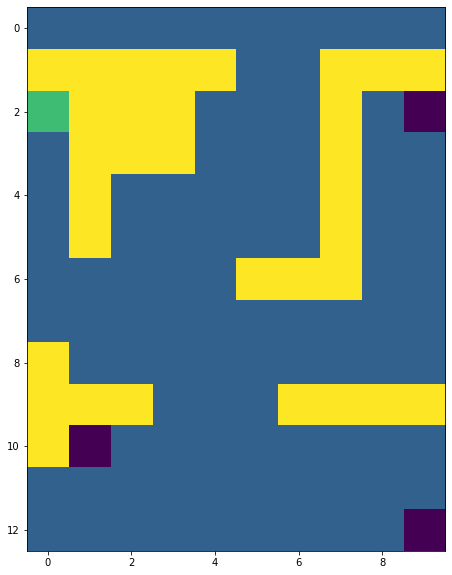

Results of the DP agent:



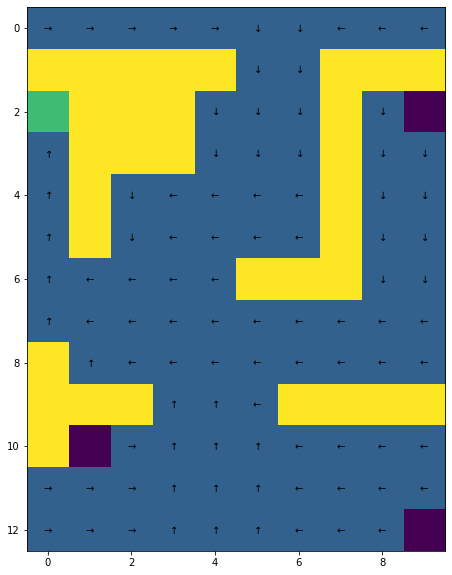

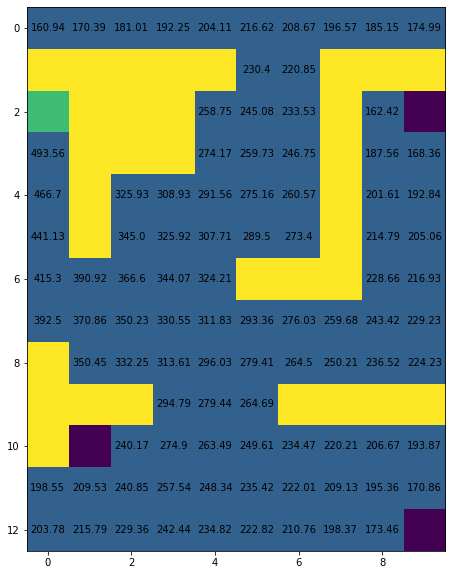

In [331]:
maze = Maze()

### Question 1: Dynamic programming
dp_agent = DP_agent()
dp_policy, dp_value = dp_agent.solve(maze)


print("Results of the DP agent:\n")
maze.get_graphics().draw_policy(dp_policy)
maze.get_graphics().draw_value(dp_value)


## 1.3 ## 

# $\rho$ #
### $\rho = 0.1$ ###

22.3 seconds

### $\rho = 0.25$ ###

12.1 seconds

### $\rho = 0.5$ ###

19.4 seconds

# $\gamma$ #
### $\gamma = 0.25$ ###

2.9 seconds

### $\gamma = 0.5$ ###

4.2 seconds

### $\gamma = 0.75$ ###

5.7 seconds


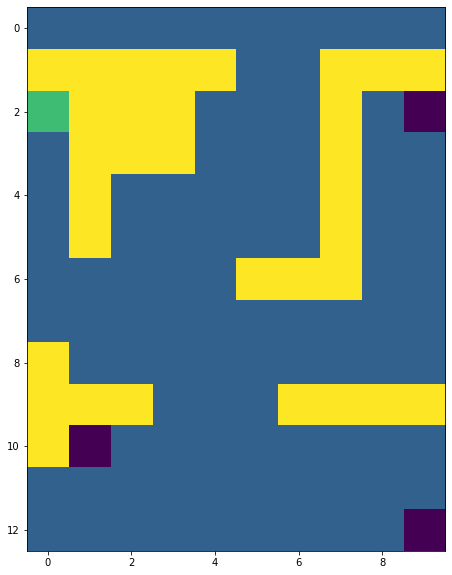

100
200
300
400
500
600
700
800
900
1000
Results of the MC agent:



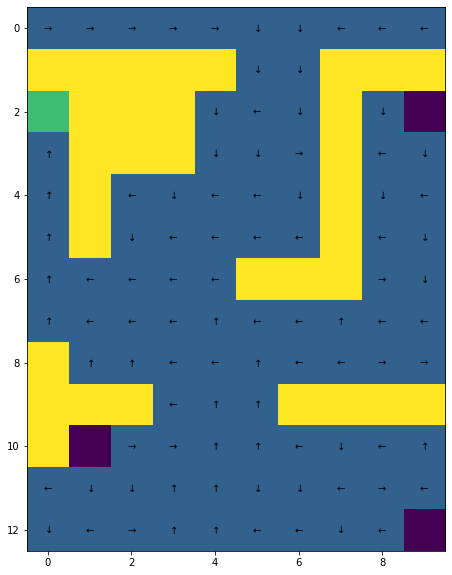

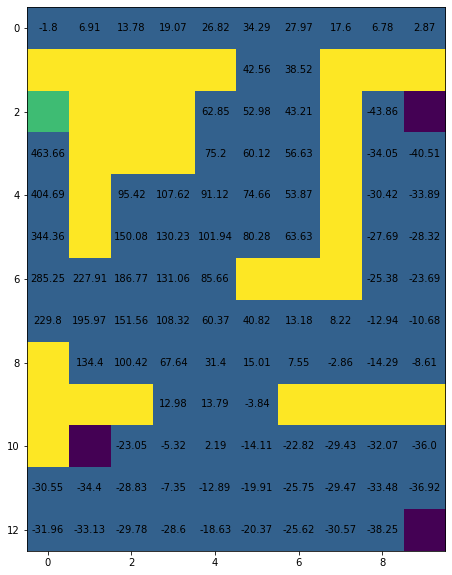

No handles with labels found to put in legend.


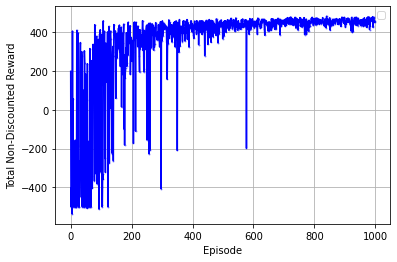

In [184]:
maze = Maze()

mc_agent = MC_agent()
mc_policy, mc_values, total_rewards = mc_agent.solve(maze)

print("Results of the MC agent:\n")
maze.get_graphics().draw_policy(mc_policy)
maze.get_graphics().draw_value(mc_values[-1])


episodes = np.arange(len(total_rewards))

plt.figure()
plt.grid()
plt.plot(episodes, total_rewards, "b.", alpha=0.4, markersize=2)
plt.plot(episodes, total_rewards, "b")
plt.xlabel("Episode")
plt.ylabel("Total Non-Discounted Reward")
plt.legend(loc="best")
plt.show()

In [276]:
def replicate_MC(num_replications):
    replication_rewards = []
    replication_values = []
    maze = Maze()
    for i in range(num_replications):
        print("Replication %i"%(i+1))
        ### Question 3: Temporal-Difference learning
        mc_agent = MC_agent()
        mc_policy, mc_values, total_rewards, episode_values = mc_agent.solve(maze)
        replication_values.append(episode_values)
        replication_rewards.append(total_rewards)

    return mc_policy, replication_values, replication_rewards

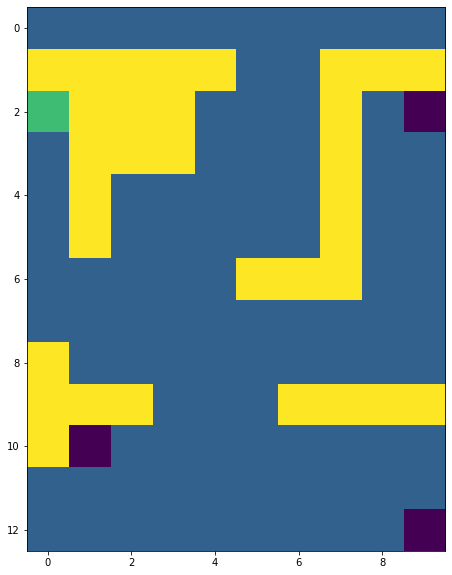

GLIE = 0.9000
Replication 1


TypeError: __init__() got an unexpected keyword argument 'chosen_param'

In [187]:
### Question 2: Monte-Carlo learning
maze = Maze()

num_replications = 25
GLIE_list = [0.9, 0.99, 0.999, 0.9999]
rewards = replicate_MC(GLIE_list, num_replications, chosen_param="GLIE")

#replication_rewards = np.array(replication_rewards)
#mean_rewards = np.mean(replication_rewards, axis=0)
#std_rewards = np.std(replication_rewards, axis=0)
#print("The standard deviation of the standard deviation across all episodes is: %.3f"%np.std(std_rewards))

print("Results of the MC agent:\n")
maze.get_graphics().draw_policy(mc_policy)
maze.get_graphics().draw_value(mc_values[-1])

for i, GLIE in enumerate(rewards):
    plt.figure()
    plt.grid() 
    mean_rewards = np.mean(np.array(rewards[i]), axis=0)
    std_rewards = np.std(np.array(rewards[i]), axis=0)
    episodes = np.arange(np.shape(np.array(rewards[i]))[1])

    plt.plot(episodes, mean_rewards, "b", label=r"$\beta = %.4f$"%GLIE)
    plt.fill_between(episodes, mean_rewards-std_rewards, mean_rewards+std_rewards, color="b", alpha=0.4)
    plt.xlabel("Episode")
    plt.ylabel("Mean Total Non-Discounted \nReward")
    plt.legend(loc = "lower right")
    plt.show()

## 2.5 ##
- Want to choose an exploration parameter that shows a total non-discounted reward with a large but stable standard deviation for the earlier episodes, indicating that it is doing a lot of exploring (sometimes it will choose a path to the final goal state that has a high total non-discounted reward and sometimes not), as well as a less steep learning curve --> this will occur for large epsilon values, as seen in the subplots in Figure #?. I found that $\epsilon = 0.95$ was appropriate when considering these objectives

- We also want that at the final stage of the learning process (later episodes) the standard deviation of the episode reward is low, indicating that the optimum path from the starting episode has been found and the agent is consistently choosing actions that lead to a high reward. 

- In terms of the GLIE parameter, we want that the agent does a lot of exploring earlier in the learning process and that in the later stages it becomes a fully greedy policy (best action found is assigned a probability of practically 1 of occuring, i.e epsilon converges to 0). I found that a value of 0.999 for the GLIE parameter allows for this to occur nicely and, in 1000 episodes, our agent seems to always end up in the goal state when reset to any one of the defined starting states ($0.999^{1000} = 0.368$, meaning by the end of the learning $\epsilon$ will have reduced by a factor of 0.368)  Nevertheless, it is always important to consider the pay-off in terms of computational efficiency of using smaller values for this parameter; for values approximating 1, the duration of each episode at the beginning of the learning process is very large since the agent explores a lot and therefore exhausts the defined limit of 500 steps much more often. However, for this environment (which is quite small), reducing $\epsilon$ by a constant factor close to 1 seemed appropriate, since the agent consistently found a policy that very close to its optimum in a reasonable amount of time. 

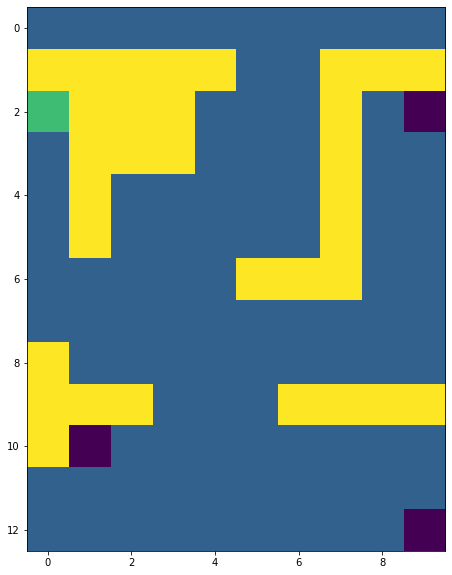

100
200
300
400
500
600
700
800
900
1000
Results of the TD agent:



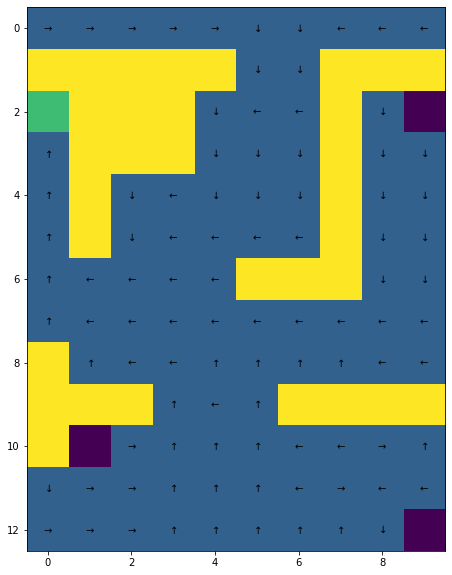

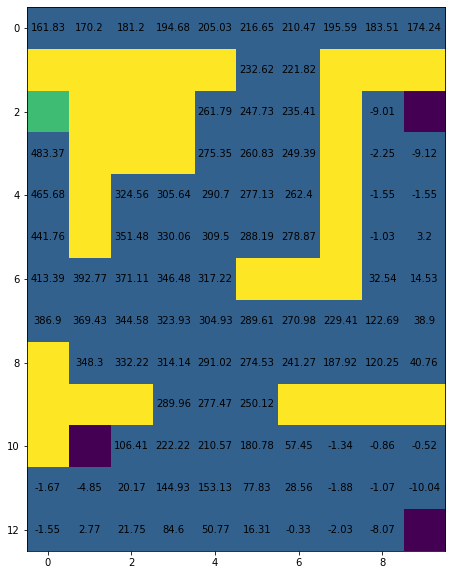

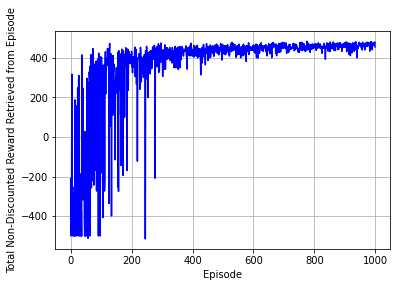

In [200]:
maze = Maze()

### Question 3: Temporal-Difference learning
epsilon = 0.95
GLIE_param = 0.999
alpha = 0.2
td_agent = TD_agent(alpha = alpha, epsilon = epsilon, GLIE_param=GLIE_param)
td_policy, td_values, total_rewards = td_agent.solve(maze)

print("Results of the TD agent:\n")
maze.get_graphics().draw_policy(td_policy)
maze.get_graphics().draw_value(td_values[-1])

episodes = np.arange(len(total_rewards))

plt.figure()
plt.grid()
plt.plot(episodes, total_rewards, "b")
plt.xlabel("Episode")
plt.ylabel("Total Non-Discounted Reward Retrieved from Episode")
plt.show()

In [277]:
def replicate_TD(num_replications):
    maze = Maze()
    replication_rewards = []
    replication_values = []
    for i in range(num_replications):
        print("Replication %i"%(i+1))
        ### Question 3: Temporal-Difference learning
        td_agent = TD_agent()
        td_policy, td_values, total_rewards, episode_values = td_agent.solve(maze)
        replication_values.append(episode_values)
        replication_rewards.append(total_rewards)

    return td_policy, replication_values, replication_rewards

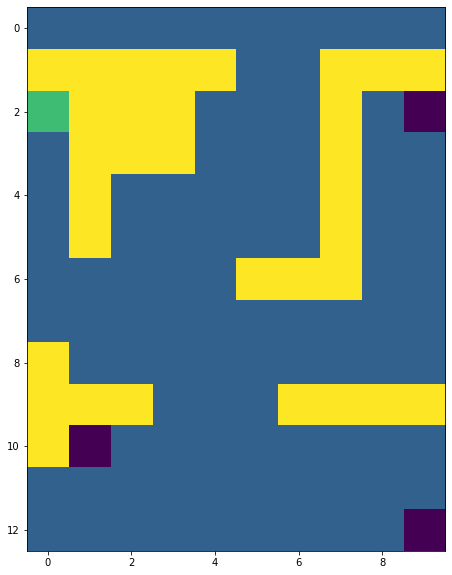

$\epsilon = 0.9500$
Replication 1
100
200
300
400
500
600
700
800
900
1000
Replication 2
100
200
300
400
500
600
700
800
900
1000
Replication 3
100
200
300
400
500
600
700
800
900
1000
Replication 4
100
200
300
400
500
600
700
800
900
1000
Replication 5
100
200
300
400
500
600
700
800
900
1000
Replication 6
100
200
300
400
500
600
700
800
900
1000
Replication 7
100
200
300
400
500
600
700
800
900
1000
Replication 8
100
200
300
400
500
600
700
800
900
1000
Replication 9
100
200
300
400
500
600
700
800
900
1000
Replication 10
100
200
300
400
500
600
700
800
900
1000
Replication 11
100
200
300
400
500
600
700
800
900
1000
Replication 12
100
200
300
400
500
600
700
800
900
1000
Replication 13
100
200
300
400
500
600
700
800
900
1000
Replication 14
100
200
300
400
500
600
700
800
900
1000
Replication 15
100
200
300
400
500
600
700
800
900
1000
Replication 16
100
200
300
400
500
600
700
800
900
1000
Replication 17
100
200
300
400
500
600
700
800
900
1000
Replication 18
100
200
300
400
500
60

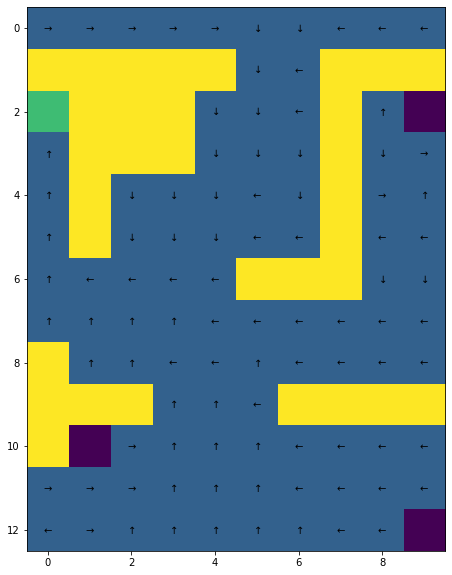

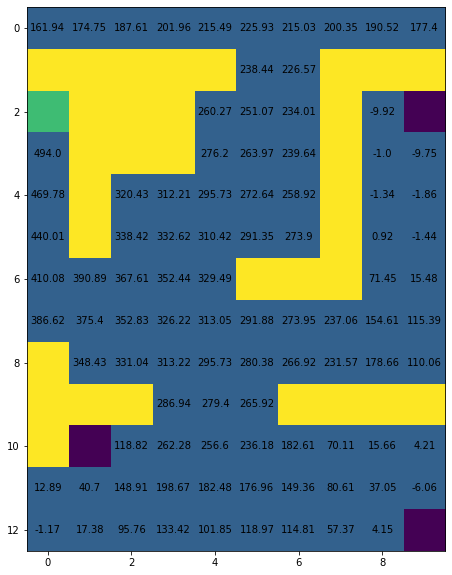

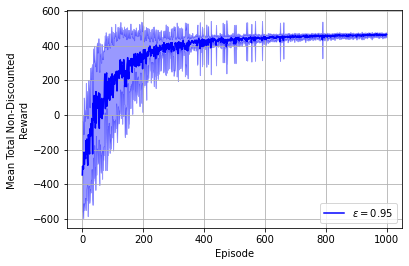

In [211]:
maze = Maze()

### Question 3: Temporal-Difference learning
epsilon = 0.95
GLIE_param = 0.999
epsilon_list = [0.95] #create 4 equally spaced values for alpha between 0 and 1

td_policy, td_values, rewards = replicate_TD(epsilon_list, 25, chosen_param = "\epsilon")

print("Results of the TD agent:\n")
maze.get_graphics().draw_policy(td_policy)
maze.get_graphics().draw_value(td_values[-1])

for i, epsilon in enumerate(epsilon_list):
    plt.figure()
    plt.grid() 
    mean_rewards = np.mean(np.array(rewards[i]), axis=0)
    std_rewards = np.std(np.array(rewards[i]), axis=0)
    episodes = np.arange(np.shape(np.array(rewards[i]))[1])

    plt.plot(episodes, mean_rewards, "b", label=r"$\epsilon = %.2f$"%epsilon)
    plt.fill_between(episodes, mean_rewards-std_rewards, mean_rewards+std_rewards, color="b", alpha=0.4)
    plt.xlabel("Episode")
    plt.ylabel("Mean Total Non-Discounted \nReward")
    plt.legend(loc = "lower right")
    plt.show()

In [221]:
from sklearn.metrics import mean_squared_error

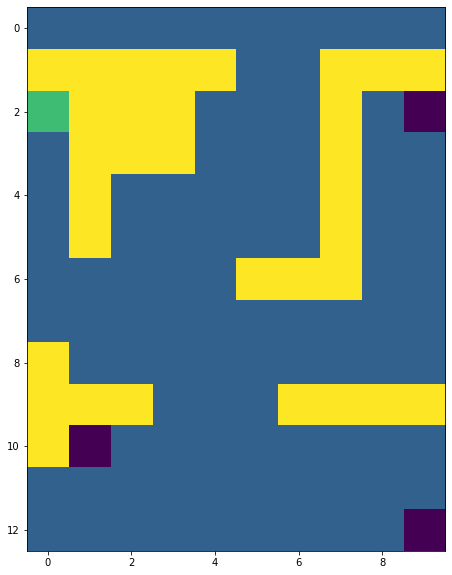

Replication 1
100
200
300
400
500
600
700
800
900
1000
Replication 2
100
200
300
400
500
600
700
800
900
1000
Replication 3
100
200
300
400
500
600
700
800
900
1000
Replication 4
100
200
300
400
500
600
700
800
900
1000
Replication 5
100
200
300
400
500
600
700
800
900
1000
Replication 6
100
200
300
400
500
600
700
800
900
1000
Replication 7
100
200
300
400
500
600
700
800
900
1000
Replication 8
100
200
300
400
500
600
700
800
900
1000
Replication 9
100
200
300
400
500
600
700
800
900
1000
Replication 10
100
200
300
400
500
600
700
800
900
1000
Replication 11
100
200
300
400
500
600
700
800
900
1000
Replication 12
100
200
300
400
500
600
700
800
900
1000
Replication 13
100
200
300
400
500
600
700
800
900
1000
Replication 14
100
200
300
400
500
600
700
800
900
1000
Replication 15
100
200
300
400
500
600
700
800
900
1000
Replication 16
100
200
300
400
500
600
700
800
900
1000
Replication 17
100
200
300
400
500
600
700
800
900
1000
Replication 18
100
200
300
400
500
600
700
800
900
1000
R

In [293]:
mc_policy, mc_rep_values, mc_rep_rewards = replicate_MC(num_replications=25)

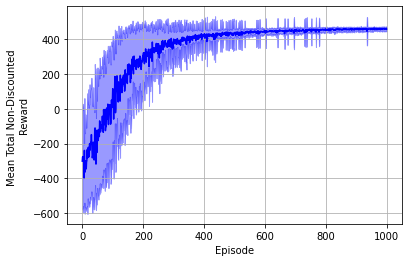

In [292]:
    plt.figure()
    plt.grid() 
    mean_rewards = np.mean(np.array(mc_rep_rewards), axis=0)
    std_rewards = np.std(np.array(mc_rep_rewards), axis=0)
    episodes = np.arange(np.shape(np.array(mc_rep_rewards))[1])

    plt.plot(episodes, mean_rewards, "b")
    plt.fill_between(episodes, mean_rewards-std_rewards, mean_rewards+std_rewards, color="b", alpha=0.4)
    plt.xlabel("Episode")
    plt.ylabel("Mean Total Non-Discounted \nReward")
    plt.show()

In [236]:
mc_mean_values = np.mean(mc_rep_values, axis = 0)
np.shape(mc_mean_values)

(1000, 98)

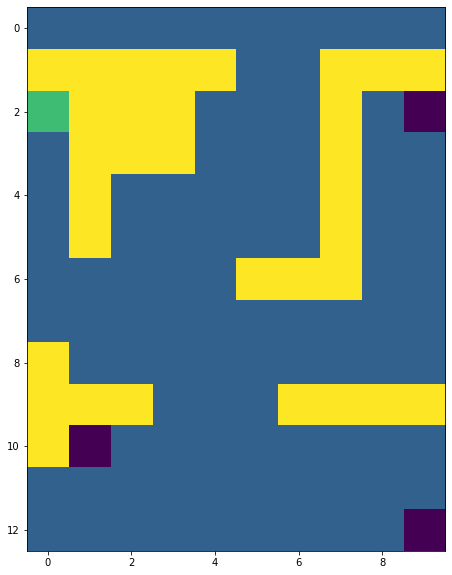

Replication 1
100
200
300
400
500
600
700
800
900
1000
Replication 2
100
200
300
400
500
600
700
800
900
1000
Replication 3
100
200
300
400
500
600
700
800
900
1000
Replication 4
100
200
300
400
500
600
700
800
900
1000
Replication 5
100
200
300
400
500
600
700
800
900
1000
Replication 6
100
200
300
400
500
600
700
800
900
1000
Replication 7
100
200
300
400
500
600
700
800
900
1000
Replication 8
100
200
300
400
500
600
700
800
900
1000
Replication 9
100
200
300
400
500
600
700
800
900
1000
Replication 10
100
200
300
400
500
600
700
800
900
1000
Replication 11
100
200
300
400
500
600
700
800
900
1000
Replication 12
100
200
300
400
500
600
700
800
900
1000
Replication 13
100
200
300
400
500
600
700
800
900
1000
Replication 14
100
200
300
400
500
600
700
800
900
1000
Replication 15
100
200
300
400
500
600
700
800
900
1000
Replication 16
100
200
300
400
500
600
700
800
900
1000
Replication 17
100
200
300
400
500
600
700
800
900
1000
Replication 18
100
200
300
400
500
600
700
800
900
1000
R

In [279]:
td_policy, td_rep_values, td_rep_rewards = replicate_TD(num_replications=25)

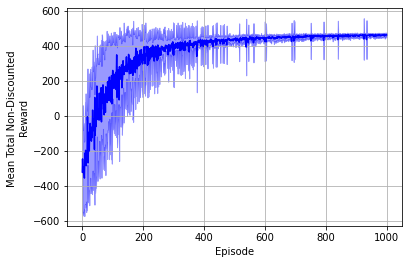

In [288]:
    plt.figure()
    plt.grid() 
    mean_rewards = np.mean(np.array(td_rep_rewards), axis=0)
    std_rewards = np.std(np.array(td_rep_rewards), axis=0)
    episodes = np.arange(np.shape(np.array(td_rep_rewards))[1])

    plt.plot(episodes, mean_rewards, "b")
    plt.fill_between(episodes, mean_rewards-std_rewards, mean_rewards+std_rewards, color="b", alpha=0.4)
    plt.xlabel("Episode")
    plt.ylabel("Mean Total Non-Discounted \nReward")
    plt.show()

In [244]:
td_mean_values = np.mean(td_rep_values, axis = 0)
np.shape(td_mean_values)

(1000, 98)

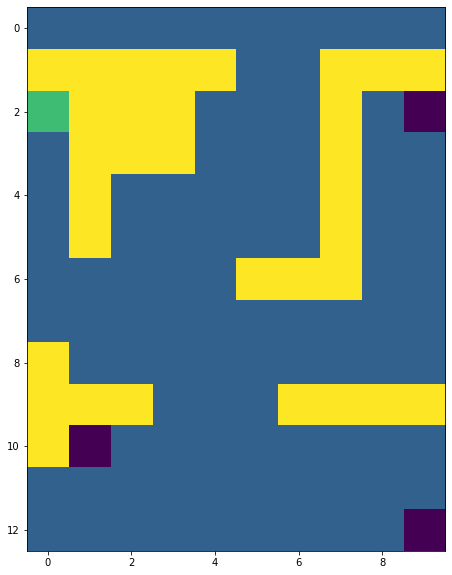

In [339]:
maze = Maze()

### Question 1: Dynamic programming
dp_agent = DP_agent()
dp_policy, dp_values = dp_agent.solve(maze)

In [333]:
def calculate_mse(dp_values, mc_rep_values, td_rep_values):  
    mse_replications_td = []
    mse_replications_mc = []
    for i in range(np.shape(td_rep_rewards)[0]):
        mse_episodes_td = []
        mse_episodes_mc = []
        for j in range(np.shape(td_rep_rewards)[1]):
            mse_td = mean_squared_error(dp_values, td_rep_values[i][j])
            mse_mc = mean_squared_error(dp_values, mc_rep_values[i][j])

            mse_episodes_td.append(mse_td)
            mse_episodes_mc.append(mse_mc)

        mse_replications_td.append(mse_episodes_td)
        mse_replications_mc.append(mse_episodes_mc)

    return mse_replications_mc, mse_replications_td

In [334]:
mse_replications_mc, mse_replications_td = calculate_mse(dp_values, mc_rep_values, td_rep_values)

In [335]:
def plot_against_DP(mse_replications_mc, mse_replications_td):
    mean_mse_td = np.mean(mse_replications_td, axis = 0)
    mean_mse_mc = np.mean(mse_replications_mc, axis = 0)
    
    std_mse_td = np.std(mse_replications_td, axis = 0)
    std_mse_mc = np.std(mse_replications_mc, axis = 0)

    episodes = np.arange(len(mean_mse_td))

    plt.figure()
    plt.grid()

    plt.plot(episodes, mean_mse_td, "b", label="TD")
    plt.fill_between(episodes, mean_mse_td-std_mse_td, mean_mse_td+std_mse_td, color="b", alpha=0.4)

    plt.plot(episodes, mean_mse_mc, "orange", label="MC")
    plt.fill_between(episodes, mean_mse_mc-std_mse_mc, mean_mse_mc+std_mse_mc, color="orange", alpha=0.4)

    plt.xlabel("Episode")
    plt.ylabel("Average Mean-Squared Error")
    plt.legend(loc = "upper right")
    plt.show()

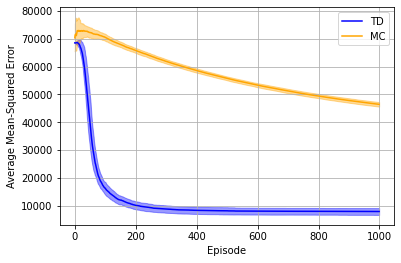

In [336]:
plot_against_DP(mse_replications_mc, mse_replications_td)

## QUESTION 4 ##

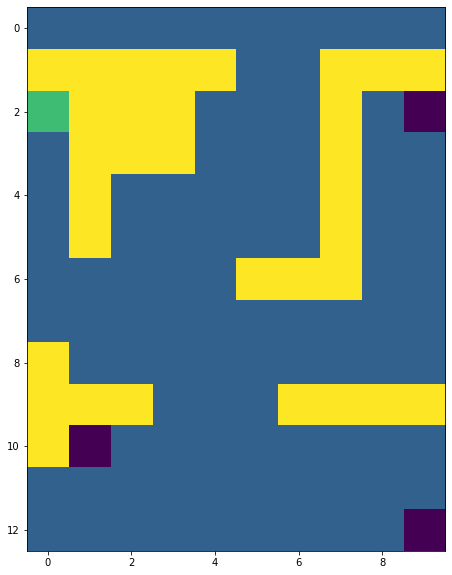

100
200
300
400
500
600
700
800
900
1000
100
200
300
400
500
600
700
800
900
1000


In [345]:
maze = Maze()

dp_agent = DP_agent()
dp_policy, dp_values = dp_agent.solve(maze)

td_agent = TD_agent()
td_policy, td_values, total_rewards_td, episode_values_td = td_agent.solve(maze)

mc_agent = MC_agent()
mc_policy, mc_values, total_rewards_mc, episode_values_mc = mc_agent.solve(maze)

In [318]:
np.shape(episode_values_td)

(1000, 98)

In [346]:
mse_episodes_td = []
mse_episodes_mc = []
for j in range(np.shape(episode_values_td)[0]):
    mse_td = mean_squared_error(dp_values, episode_values_td[j])
    mse_mc = mean_squared_error(dp_values, episode_values_mc[j])

    mse_episodes_td.append(mse_td)
    mse_episodes_mc.append(mse_mc)

In [347]:
np.shape(mse_episodes_mc)

(1000,)

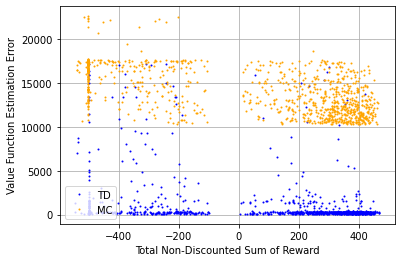

In [348]:
plt.figure()
plt.grid()
plt.plot(total_rewards_td, mse_episodes_td, "b.", markersize=2, label = "TD")
plt.plot(total_rewards_mc, mse_episodes_mc, ".", color="orange", markersize=2, label= "MC")
plt.xlabel("Total Non-Discounted Sum of Reward")
plt.ylabel("Value Function Estimation Error")
plt.legend(loc = "lower left")
plt.show()